# Udacity Deep Reinforcement Learning Nanodegree - Project 1: "Navigation"

---

The following notebook trains an agent's policy with Deep Double Q-Learning (DDQN) to collect yellow bananas in a virtual environment. 
Before getting started, check carefully to satisfy the criteria of the [Deep Reinforcement Learning Nanodegree]  (https://github.com/udacity/deep-reinforcement-learning/#dependencies).

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


### Prerequisites

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

Next, we will start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

  -**Mac**: "path/to/Banana.app"  
  -**Windows (x86)**: "path/to/Banana_Windows_x86/Banana.exe"  
  -**Windows (x86_64)**: "path/to/Banana_Windows_x86_64/Banana.exe"  
  -**Linux (x86)**: "path/to/Banana_Linux/Banana.x86"  
  -**Linux (x86_64)**: "path/to/Banana_Linux/Banana.x86_64"  
  -**Linux (x86, headless)**: "path/to/Banana_Linux_NoVis/Banana.x86"  
  -**Linux (x86_64, headless)**: "path/to/Banana_Linux_NoVis/Banana.x86_64"  
    
For instance, if you are using a Mac, then you downloaded Banana.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

    env = UnityEnvironment(file_name="Banana.app")

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

Instructions on who to complete this challenge are open ended. In this repository, the agent is implemented using a Double Deed Q-Learning Network (DDQN) as its policy in PyTorch. The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

    0 - move forward.
    1 - move backward.
    2 - turn left.
    3 - turn right.

In [21]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 0.          1.          0.          0.          0.50285321  0.          0.
  1.          0.          0.06990992  1.          0.          0.          0.
  0.58848524  1.          0.          0.          0.          0.17747687
  0.          0.          1.          0.          0.64808053  0.          0.
  1.          0.          0.07544678  0.          0.          1.          0.
  0.49621376  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


In [7]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import random
import qnetwork, replaybuffer, dqn_agent, ddqn_agent
from dqn_agent import DQN_Agent
from ddqn_agent import DDQN_Agent

### 4. Launch the Agent

Initialize the agent.
In this notebook, two options are available: Either a classic **DQN** agent or an improved version (**DDQN**) using double Q Deep Learning to prevent overestimation of Q-values in the agent's policy update step as suggest by [Hado van Hasselt et al.](https://arxiv.org/pdf/1509.06461.pdf) at Google DeepMind in 2010.


The **Neural Network architecture** currently consistes of **hree linear layers**, containing an input dimension of 37, 2 hidden dimensions of 40 and 10 nodes and returns 4 outputs. Network parameters can be **modified** in the `qnetwork.py` file. 

For training the agent preset **hyperparameters** are:

    GAMMA = 0.995
    TAU = 1e-3
    LR = 5e-4
    UPDATE_EVERY = 4
    BUFFER_SIZE = int(1e5)
    BATCH_SIZE = 64
    
These can be adjusted in the `ddqn_agent.py` and `ddqn_agent.py` files, respectively.

In [8]:
agent = DDQN_Agent(state_size=state_size, action_size=action_size, seed=123)

### 5. Train an intelligent agent

If available, training is executed on a GPU using CUDA. 
Numbers of epochs, maximum time length per epoch and epsilon (for epsilon-greedy policy) can be modified in this function.

In [9]:
def train(n_episodes=4000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    """ Deep Q Learning training iterations.
    ===========
    PARAMETERS
    ==========
        n_episodes (int) = maximum number of training episodes
        max_t (int) = maximum timesteps per episode
        eps_start (float) = starting value of epsilon for epsilon greedy decision
        eps_end (float) = minimum epsilon value
        eps_decay (float) = multiplicative factor for decreasing epsilon at each episodes
    """
    
    scores = []                              # type=list, contains scores for every episode
    scores_window = deque(maxlen=100)        # contain last 100 scores
    eps = eps_start                          # set epsilon to 1.0 as defined above
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]               # set train to True
        state = env_info.vector_observations[0]
        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)#.astype(int)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            eps = max(eps_end, eps_decay*eps)  # decrease epsilon to move from exploration to exploitation
            
            if done:
                break
        
        scores_window.append(score)
        scores.append(score)
        
        print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_window)), end = "")
        if i_episode % 100 == 0:
            print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print("\nEnvironment solved in {:d} episodes! \tAverage Score: {:.2f}".format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), "checkpoint.pth")
            break
    
    return scores     

In [10]:
# execute training and monitor progress
scores = train(n_episodes=4000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

Episode 100	Average Score: 0.31
Episode 200	Average Score: 2.01
Episode 300	Average Score: 4.70
Episode 400	Average Score: 9.36
Episode 500	Average Score: 12.78
Episode 503	Average Score: 13.04
Environment solved in 403 episodes! 	Average Score: 13.04


### 6. Plot learning progress

This figure is also saved as `DDQN_Result.jpg` in this directory.

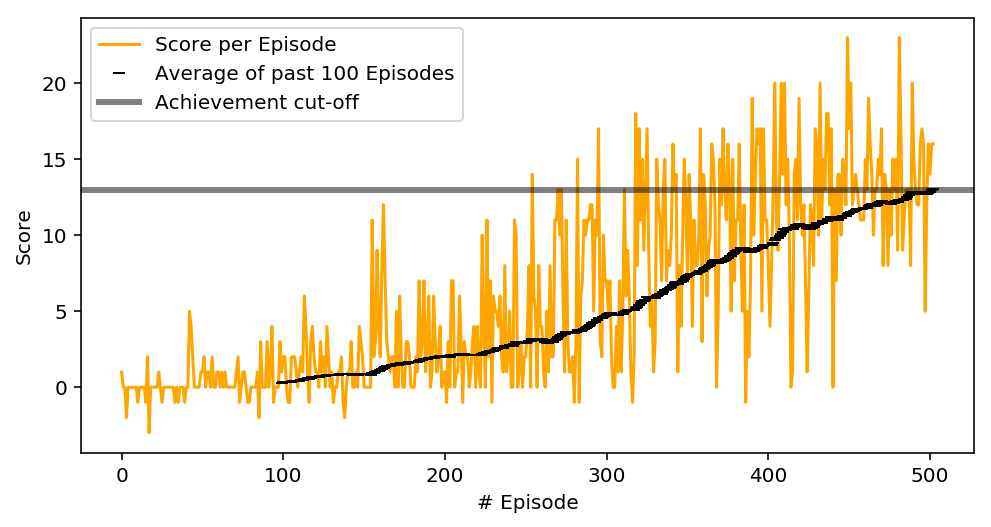

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"

fig, axis = plt.subplots(1,1, figsize = [8,4])
rolling_scores_pd = pd.Series(scores).rolling(100).mean()

axis.plot(scores, "-", c="orange")
axis.plot(rolling_scores_pd, "_", c="black", linewidth=1)
axis.axhline(13, c="black", linewidth=3, alpha=0.5)
axis.set_xlabel("# Episode")
axis.set_ylabel("Score")
axis.legend(["Score per Episode", "Average of past 100 Episodes", "Achievement cut-off"])

fig.savefig("DDQN_Result.jpg")

### 7. Use the agent to play the game

Pretrained weights can now be used to visualise the agents ability in collecting yellow bananas.
Here, **eps=0** as defined in the `dqn_agent.py` file as a default, so other than in training (where epsilon was consistently decreased after each episode), always the **greedy** = most intelligent action at this time point is chosen.


In [23]:
# load saved weights from "checkpoint.pth" into the agents local q-network
agent.qnetwork_local.load_state_dict(torch.load("checkpoint.pth"))

for _ in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    
    for _ in range(100):
        action = agent.act(state)                  # choose action from policy
        env_info = env.step(action)[brain_name]    # perform action
        state = env_info.vector_observations[0]    # recieve new state
        done = env_info.local_done[0]              # see if done, then break
        if done:
            break
            
env.close()                                        # finally, close the envrironment